# Density-based novelty detection

### 1.Unigaussian.ipynb

In [1]:
#For plotting
import matplotlib.pyplot as plt
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for plotting
import seaborn as sns
sns.set_style("white")
%matplotlib inline

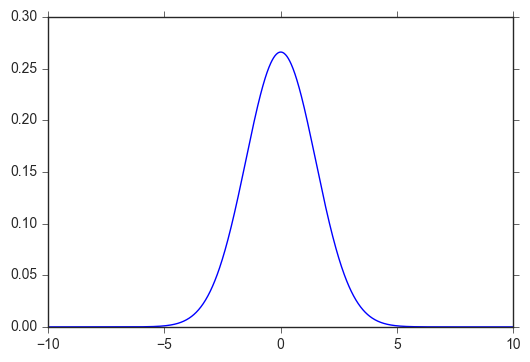

In [2]:
#Return evenly spaced numbers over a specified interval.
x = np.linspace(start=-10, stop=10, num=1000)
#A normal continuous random variable.
#The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation.
y = stats.norm.pdf(x, loc=0, scale=1.5)
#plot it!
plt.plot(x, y)

In [3]:
import pandas as pd

In [5]:
df = pd.read_csv("1_iris_virginica.csv")
df.head(n=5)

sepallength  sepalwidth  petallength  petalwidth    label
0          5.1         3.5          1.4         0.2  outlier
1          4.9         3.0          1.4         0.2  outlier
2          4.7         3.2          1.3         0.2  outlier
3          4.6         3.1          1.5         0.2  outlier
4          5.0         3.6          1.4         0.2  outlier

In [6]:
#단별량 데이터 구현
y = pd.DataFrame.as_matrix(df[['sepallength']])
print(y.shape)
print(y[0:5])

(150, 1)
[[5.1]
 [4.9]
 [4.7]
 [4.6]
 [5. ]]


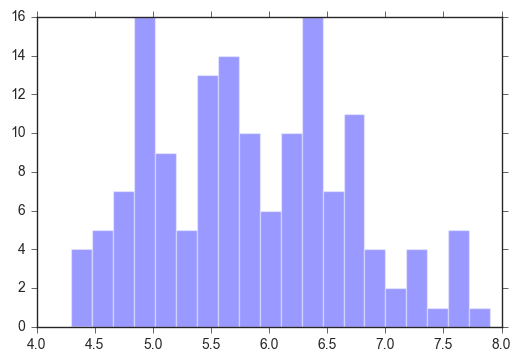

In [7]:
sns.distplot(y, bins=20, kde = False)

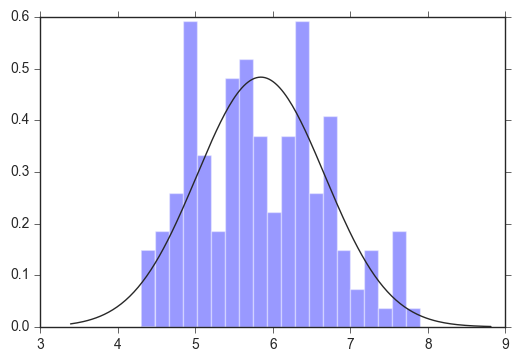

In [8]:
#package seabon을 이용하여 gaussian분포 추정
sns.distplot(y, fit=stats.norm, bins=20, kde=False,)

In [9]:
class Gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def pdf(self, data): # 가우시안 분포 pdf 값 return
        u = (data - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y

In [10]:
# pdf 값 즉 정규 분포의 확률값이 최대 값이 되는 mu와 sigma는 평균과 분산이다.
best= Gaussian(np.mean(y), np.std(y))
print("best mu=" , best.mu)
print("best sigma=", best.sigma)

best mu= 5.843333333333334
best sigma= 0.8253012917851409


[[5.1]
 [4.9]
 [4.7]
 [4.6]
 [5. ]]


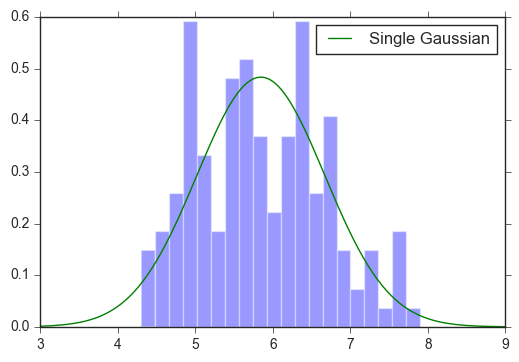

In [11]:
# 가우시안 분포 그리기
x = np.linspace(3,9,200)
g_single = stats.norm(best.mu, best.sigma).pdf(x)
sns.distplot(y, bins=20, kde = False, norm_hist= True)
plt.plot(x,g_single, label = 'Single Gaussian')
plt.legend()

print(y[0:5])

In [12]:

#정상 boundary 외 outlier filtering
n = 0
b=0
for i in range(0,y.shape[0]):
    if (stats.norm(best.mu, best.sigma).pdf(y[i])) >0.05 and (stats.norm(best.mu, best.sigma).pdf(y[i])) < 0.995:
        print(y[i],"= normal")
        n=n+1
    else:
        print(y[i],"=abnormal")
        b=b+1

print("normal=",n)
print("abnormal=",b)

[5.1] = normal
[4.9] = normal
[4.7] = normal
[4.6] = normal
[5.] = normal
[5.4] = normal
[4.6] = normal
[5.] = normal
[4.4] = normal
[4.9] = normal
[5.4] = normal
[4.8] = normal
[4.8] = normal
[4.3] = normal
[5.8] = normal
[5.7] = normal
[5.4] = normal
[5.1] = normal
[5.7] = normal
[5.1] = normal
[5.4] = normal
[5.1] = normal
[4.6] = normal
[5.1] = normal
[4.8] = normal
[5.] = normal
[5.] = normal
[5.2] = normal
[5.2] = normal
[4.7] = normal
[4.8] = normal
[5.4] = normal
[5.2] = normal
[5.5] = normal
[4.9] = normal
[5.] = normal
[5.5] = normal
[4.9] = normal
[4.4] = normal
[5.1] = normal
[5.] = normal
[4.5] = normal
[4.4] = normal
[5.] = normal
[5.1] = normal
[4.8] = normal
[5.1] = normal
[4.6] = normal
[5.3] = normal
[5.] = normal
[7.] = normal
[6.4] = normal
[6.9] = normal
[5.5] = normal
[6.5] = normal
[5.7] = normal
[6.3] = normal
[4.9] = normal
[6.6] = normal
[5.2] = normal
[5.] = normal
[5.9] = normal
[6.] = normal
[6.1] = normal
[5.6] = normal
[6.7] = normal
[5.6] = normal
[5.8] 

### 2.MixtureGaussian.ipynb

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Ellipse
import scipy as sc
from scipy import random, linalg, stats, special

In [16]:
df = pd.read_csv("1_iris_virginica.csv")
df.head(n=5)

sepallength  sepalwidth  petallength  petalwidth    label
0          5.1         3.5          1.4         0.2  outlier
1          4.9         3.0          1.4         0.2  outlier
2          4.7         3.2          1.3         0.2  outlier
3          4.6         3.1          1.5         0.2  outlier
4          5.0         3.6          1.4         0.2  outlier

In [27]:
#데이터를 matrix 형식으로 만들어 줌
y = pd.DataFrame.as_matrix(df[['sepallength','sepalwidth','petallength','petalwidth']])#,'sepalwidth ','petallength','petalwidth ']])
y.shape
print(y[0:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


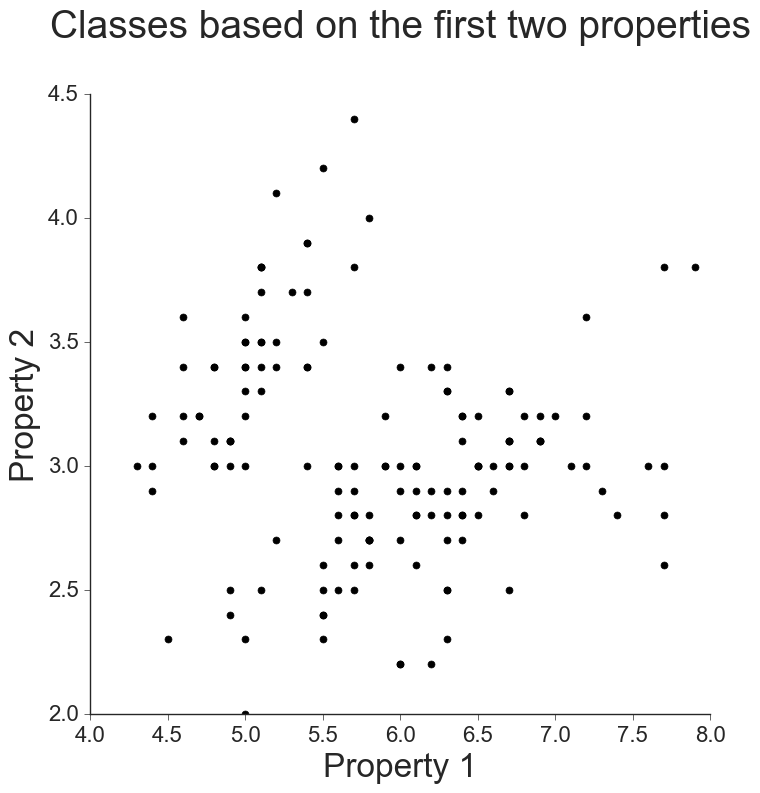

In [28]:
# 1열과 2열 데이터만 가지고 2차원 그래프 생성
plotsize = 8
sizeMean =10
text_size = 16
axis_font = {'fontname':'Arial', 'size':'24'}
Title_font= {'fontname':'Arial', 'size':'28'}
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(y[:,0], y[:,1], 'k.', markersize= sizeMean)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Property 2', **axis_font)
ax.set_xlabel('Property 1', **axis_font)
ax.set_title('Classes based on the first two properties', y=1.08, **Title_font)
ax.figure.set_size_inches(plotsize, plotsize)

plt.show()


In [29]:
y.shape

(150, 4)

In [30]:
#parameters
NProperties = y.shape[1] #variable의 갯수 
NClasses = 6             # 몇개의 class로 나눌것인가 , 가우시간 분포 갯수, Hyper parameter
NObjects = y.shape[0]    # 데이터의 행 데이터 갯수

In [31]:
# 초기 Mu, Cov 값 크기 설정
initMu = np.empty([NClasses, NProperties])
initCov = np.empty([NProperties, NProperties, NClasses])
print("initMu size =" ,initMu.shape)
print("initCov size =", initCov.shape)

initMu size = (6, 4)
initCov size = (4, 4, 6)


In [32]:
#sd 를 가지는 n*n 의 양의 matrix를 만들어 내는 함수 (초기값을 주기 위해 생성)
def PosSymDefMatrix(n,sd):
    M = np.matrix(np.random.rand(n,n))
    M = 0.5*(M + M.T)
    M = M + sd*np.eye(n)
    return M

In [33]:
Cov = [PosSymDefMatrix(NProperties,i) for i in range(0,NClasses)]
for j in range(NClasses):
    initMu[j, :] = np.random.random(NProperties) * np.amax(y, axis=0)
    initCov[:, :, j] = np.mean(np.array(Cov), axis=0) + 2
    
print("initMu=" ,initMu) # average
print("initCov=" ,initCov) # sigma
print("Cov=", Cov)
theta = np.repeat(1.0/NClasses,NClasses)

initMu= [[5.21038084 1.88623767 2.62670813 0.66999728]
 [1.00876518 2.11485868 6.4663991  2.00931956]
 [4.59883493 3.81835557 0.37755703 1.65165284]
 [0.51460905 4.04949859 6.31700488 1.11322233]
 [7.3139238  2.7919684  1.24739023 0.39391281]
 [1.44815574 3.9563126  0.69015432 0.99522898]]
initCov= [[[4.91148102 4.91148102 4.91148102 4.91148102 4.91148102 4.91148102]
  [2.52794743 2.52794743 2.52794743 2.52794743 2.52794743 2.52794743]
  [2.39428614 2.39428614 2.39428614 2.39428614 2.39428614 2.39428614]
  [2.49713559 2.49713559 2.49713559 2.49713559 2.49713559 2.49713559]]

 [[2.52794743 2.52794743 2.52794743 2.52794743 2.52794743 2.52794743]
  [5.10499617 5.10499617 5.10499617 5.10499617 5.10499617 5.10499617]
  [2.43219085 2.43219085 2.43219085 2.43219085 2.43219085 2.43219085]
  [2.51348749 2.51348749 2.51348749 2.51348749 2.51348749 2.51348749]]

 [[2.39428614 2.39428614 2.39428614 2.39428614 2.39428614 2.39428614]
  [2.43219085 2.43219085 2.43219085 2.43219085 2.43219085 2.432190

In [34]:
print ('각각 class의 가중치 확률 theta '+str(NClasses))
print (theta)
initW = theta

각각 class의 가중치 확률 theta 6
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


In [35]:
#EM Algorithm 구현 Expectation
def EStep(y, w, mu, cov): 
    r_ij = np.zeros((y.shape[0], mu.shape[0]))

    for Object in range(y.shape[0]):

        r_ij_Sumj = np.zeros(mu.shape[0])

        for jClass in range(mu.shape[0]):
            r_ij_Sumj[jClass] = w[jClass] * sc.stats.multivariate_normal.pdf(y[Object, :], mu[jClass, :],cov[:, :, jClass])

        for jClass in range(r_ij_Sumj.shape[0]):
            r_ij[Object, jClass] = r_ij_Sumj[jClass] / np.sum(r_ij_Sumj)

    return r_ij

r_n = EStep(y, initW, initMu, initCov)
print (r_n[0:5,:])

[[3.14943147e-01 6.43825421e-05 3.66678961e-01 8.38900530e-05
  2.65432504e-01 5.27971156e-02]
 [3.81191457e-01 1.10246971e-04 3.23839597e-01 1.04465147e-04
  2.46508891e-01 4.82453428e-02]
 [3.36542007e-01 1.22166948e-04 3.82045718e-01 1.41595813e-04
  2.09365254e-01 7.17832575e-02]
 [3.83433736e-01 2.19489733e-04 3.49705876e-01 2.37884677e-04
  1.90681882e-01 7.57211312e-02]
 [3.02762014e-01 7.43279773e-05 3.90276698e-01 1.06647616e-04
  2.42486729e-01 6.42935845e-02]]


In [36]:
#EM Algorithm 구현 Maximazation
def MStep(r, y, mu, cov):
    N = y.shape[0]

    # the weigths , Estep의 평균
    w_j = np.sum(r, axis=0) / N

    Allmu_j = np.zeros((N, mu.shape[0], mu.shape[1]))
    Allcov_j = np.zeros((N, cov.shape[0], cov.shape[1], cov.shape[2]))

    # mean
    for Object in range(N):
        Allmu_j[Object, :, :] = np.outer(r[Object, :], y[Object, :])

    mu_j = np.zeros((mu.shape[0], mu.shape[1]))

    for j in range(cov.shape[2]):
        mu_j[j, :] = (1 / np.sum(r, axis=0)[j]) * np.sum(Allmu_j, axis=0)[j, :]

    # sd
    for Object in range(N):
        for j in range(cov.shape[2]):
            Allcov_j[Object, :, :, j] = r[Object, j] * np.outer((y[Object, :] - mu_j[j, :]),
                                                                (y[Object, :] - mu_j[j, :]))

    cov_j = np.zeros((cov.shape[0], cov.shape[1], cov.shape[2]))

    for j in range(cov.shape[2]):
        cov_j[:, :, j] = (1 / np.sum(r, axis=0)[j]) * np.sum(Allcov_j, axis=0)[:, :, j]

    return w_j, mu_j, cov_j

w_n,mu_n,cov_n = MStep(r_n, y, initMu, initCov)
print(w_n)
print(mu_n)
print(cov_n)

[0.66231328 0.00524095 0.1488495  0.00134802 0.15768158 0.02456667]
[[6.05779491 2.95687815 4.35743473 1.44751696]
 [6.1588354  2.89578565 5.13532656 1.85973005]
 [5.19253241 3.31819561 2.0525507  0.49783367]
 [6.03735469 2.91567891 4.91948759 1.76072867]
 [5.66110719 3.18466299 3.06600332 0.89793283]
 [5.09635676 3.27430714 2.04182416 0.49444845]]
[[[ 0.61797812  0.41326505  0.31799385  0.41174121  0.64562564
    0.28279636]
  [ 0.02427008  0.10263822  0.01041977  0.09807009 -0.06432921
    0.01321475]
  [ 1.00794511  0.40111546  0.55185183  0.47362183  1.24310811
    0.50497459]
  [ 0.40286481  0.14127564  0.23525783  0.18857384  0.50245463
    0.21789041]]

 [[ 0.02427008  0.10263822  0.01041977  0.09807009 -0.06432921
    0.01321475]
  [ 0.14846195  0.10614874  0.19478916  0.11072354  0.2126661
    0.18360689]
  [-0.1218084   0.10694009 -0.25690059  0.07858548 -0.4113357
   -0.24134697]
  [-0.03286434  0.07237815 -0.09898731  0.05718938 -0.15581048
   -0.09580908]]

 [[ 1.00794511 

In [37]:
# implement EM algorithm
Inititeration = 100
EMiteration = 40
lookLH = 20

In [38]:
for init in range(Inititeration):

    # starting values
    initMu = np.empty([NClasses, NProperties])
    for j in range(NClasses):
        initMu[j, :] = np.random.random(NProperties) * np.amax(y, axis=0)

    r_n = EStep(y, initW, initMu, initCov)
    w_n, mu_n, cov_n = MStep(r_n, y, initMu, initCov)

    if init == 0:
        logLH = -1000000000000

    for i in range(EMiteration):

        # E step
        r_n = EStep(y, w_n, mu_n, cov_n)

        # M step
        w_n, mu_n, sigma_n = MStep(r_n, y, mu_n, cov_n)

        # log likelihood를 계산 
        logLall = np.zeros((y.shape[0]))

        for Object in range(y.shape[0]):

            LH = np.zeros(NClasses)

            for jClass in range(NClasses):
                LH[jClass] = w_n[jClass] * sc.stats.multivariate_normal.pdf(y[Object, :], mu_n[jClass, :],
                                                                            cov_n[:, :, jClass])

            logLall[Object] = np.log(np.sum(LH))

        logL = np.sum(logLall)

        if i > EMiteration - lookLH:
            print(logL)

    if logL > logLH:
        logLH = logL
        print('found larger: ', logLH)
        w_p = w_n
        mu_p = mu_n
        sigma_p = sigma_n
        r_p = r_n

-301.13114807073583
-300.887714846423
-300.6512462586235
-300.41886598626803
-300.1879807161509
-299.9579331382163
-299.7303016417564
-299.50616512827804
-299.2847263031273
-299.06517319925143
-298.8474230250264
-298.6317589266651
-298.4185797446632
-298.20832179168053
-298.00142958804497
-297.7983317589541
-297.59941555632986
-297.4050046390235
-297.21534712688396
found larger:  -297.21534712688396
-303.94183590546015
-303.91222441070295
-303.88855513341235
-303.8696000887918
-303.85439203907106
-303.84216762746837
-303.8323232631438
-303.8243808117914
-303.81796085037
-303.8127617715367
-303.80854342282703
-303.8051142697342
-303.8023213037952
-303.80004209400784
-303.7981785155538
-303.796651793903
-303.7953985824821
-303.79436785391806
-303.7935184327439
-294.6069259202843
-294.48252848121234
-294.39771029703115
-294.3446889312936
-294.30940329141555
-294.28236461114204
-294.259653680254
-294.23988597279777
-294.2224704033538
-294.20705045121383
-294.1933576680898
-294.181172185959

In [39]:
print ("mu=", mu_n)
print("sigma=",cov_n)

mu= [[5.15603018 3.34165097 1.93189438 0.43873694]
 [5.21507522 3.25789653 2.13086146 0.51388508]
 [5.13775791 3.30108846 1.97582493 0.45822869]
 [5.19802133 3.23984205 2.13941622 0.51714378]
 [4.67569182 2.32367007 1.69255389 0.43601257]
 [6.30364145 2.88028394 4.96561924 1.700336  ]]
sigma= [[[ 0.48587273  0.63572764  0.48923     0.62363119  0.66348012
    0.52426338]
  [-0.03617192 -0.05490409 -0.02465158 -0.04227383  0.01718558
    0.08087383]
  [ 0.99142092  1.2262495   0.98442211  1.18776629  1.07846286
    0.62580028]
  [ 0.42585401  0.50703832  0.42374088  0.48969448  0.41478744
    0.21300875]]

 [[-0.03617192 -0.05490409 -0.02465158 -0.04227383  0.01718558
    0.08087383]
  [ 0.19380495  0.20297145  0.1786718   0.1911978   0.15546902
    0.11558586]
  [-0.35370187 -0.37937996 -0.31296327 -0.33781161 -0.14288882
    0.06266827]
  [-0.13900103 -0.14286191 -0.12131519 -0.12540063 -0.04175248
    0.048587  ]]

 [[ 0.99142092  1.2262495   0.98442211  1.18776629  1.07846286
    0.6

In [40]:
# 판정
mul_pdf =np.zeros(NClasses)
tot=0
for i in range(0, y.shape[0]):
    n = 0
    b = 0
    for jClass in range(0,NClasses):
        mul_pdf[jClass] = sc.stats.multivariate_normal.pdf(y[i, :], mu_p[jClass, :],sigma_p[:, :, jClass])
        if mul_pdf[jClass] > 0.025 and mul_pdf[jClass] < 0.975:
            n=n+1
        else:
            b =b+1
    if n==0:
        tot = tot+1
        print("abnormal =", y[i,:])
print("abnormal count=", tot)
print("normal count =" ,y.shape[0]-tot)

abnormal = [5.1 3.5 1.4 0.2]
abnormal = [4.9 3.  1.4 0.2]
abnormal = [4.7 3.2 1.3 0.2]
abnormal = [4.6 3.1 1.5 0.2]
abnormal = [5.  3.6 1.4 0.2]
abnormal = [5.4 3.9 1.7 0.4]
abnormal = [4.6 3.4 1.4 0.3]
abnormal = [5.  3.4 1.5 0.2]
abnormal = [4.4 2.9 1.4 0.2]
abnormal = [4.9 3.1 1.5 0.1]
abnormal = [5.4 3.7 1.5 0.2]
abnormal = [4.8 3.4 1.6 0.2]
abnormal = [4.8 3.  1.4 0.1]
abnormal = [5.4 3.9 1.3 0.4]
abnormal = [5.1 3.5 1.4 0.3]
abnormal = [5.7 3.8 1.7 0.3]
abnormal = [5.1 3.8 1.5 0.3]
abnormal = [5.4 3.4 1.7 0.2]
abnormal = [5.1 3.7 1.5 0.4]
abnormal = [5.  3.  1.6 0.2]
abnormal = [5.  3.4 1.6 0.4]
abnormal = [5.2 3.5 1.5 0.2]
abnormal = [5.2 3.4 1.4 0.2]
abnormal = [4.7 3.2 1.6 0.2]
abnormal = [4.8 3.1 1.6 0.2]
abnormal = [5.4 3.4 1.5 0.4]
abnormal = [5.5 4.2 1.4 0.2]
abnormal = [4.9 3.1 1.5 0.1]
abnormal = [5.  3.2 1.2 0.2]
abnormal = [5.5 3.5 1.3 0.2]
abnormal = [4.9 3.1 1.5 0.1]
abnormal = [4.4 3.  1.3 0.2]
abnormal = [5.1 3.4 1.5 0.2]
abnormal = [5.  3.5 1.3 0.3]
abnormal = [4.

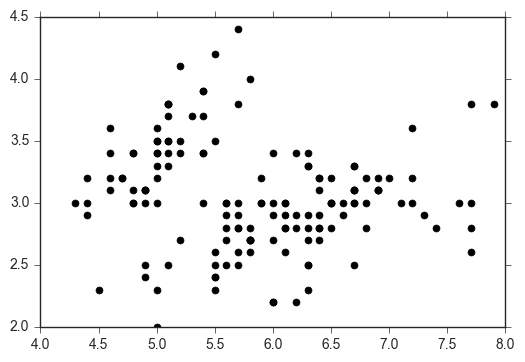

In [41]:

#gaussian plot
# plot parameters
plotsize = 8
sizeMean = 10
text_size = 16
axis_font = {'fontname': 'Arial', 'size': '24'}
Title_font = {'fontname': 'Arial', 'size': '28'}
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.plot(y[:, 0], y[:, 1], 'k.', markersize=sizeMean)

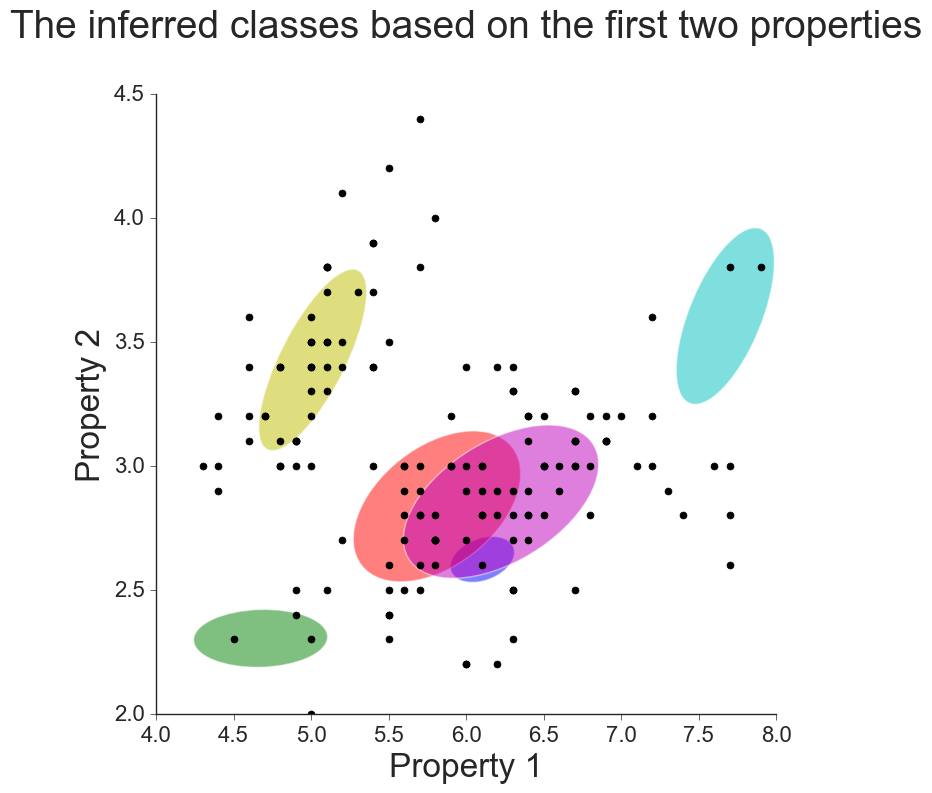

In [42]:
#gaussian plot
# plot parameters
plotsize = 8
sizeMean = 10
text_size = 16
axis_font = {'fontname': 'Arial', 'size': '24'}
Title_font = {'fontname': 'Arial', 'size': '28'}
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.plot(y[:, 0], y[:, 1], 'k.', markersize=sizeMean)

for i in range(NClasses):
    # the sd with ellipses
    # central point of the error ellipse
    pos = [mu_p[i, 0], mu_p[i, 1]]

    # for the angle we need the eigenvectors of the covariance matrix
    w, ve = np.linalg.eig(sigma_p[0:2, 0:2, i])

    # We pick the largest eigen value
    order = w.argsort()[::-1]
    w = w[order]
    ve = ve[:, order]

    # we compute the angle towards the eigen vector with the largest eigen value
    thetaO = np.degrees(np.arctan(ve[1, 0] / ve[0, 0]))

    # Compute the width and height of the ellipse based on the eigen values (ie the length of the vectors)
    width, height = 2 * np.sqrt(w)

    # making the ellipse
    ellip = Ellipse(xy=pos, width=width, height=height, angle=thetaO)
    ellip.set_alpha(0.5)
    ellip.set_facecolor(color[i])

    ax.add_artist(ellip)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Property 2', **axis_font)
ax.set_xlabel('Property 1', **axis_font)
ax.set_title('The inferred classes based on the first two properties', y=1.08, **Title_font)
ax.figure.set_size_inches(plotsize, plotsize)

plt.show()

### 3.Local Outlier Factor.ipynb

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as sc
from scipy import stats
import seaborn as sns
sns.set_style("white")
import pandas as pd
import math as mt
from random import uniform
import random

#Data Generation (IRIS, Sepal length, Sepal Width)
data = [[5.1, 3.5], [4.9, 3], [4.7, 3.2], [4.6, 3.1], [5, 3.6], [5.4, 3.9], [4.6, 3.4], [5, 3.4], [4.4, 2.9], [4.9, 3.1]]
idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
df = pd.DataFrame(data, columns=['X', 'Y'], index=idx)

#Array, Variables
lrd = []
inpointidx = []
knnidx = []
LOF = []
lrdko = []
a = 0

#Euclidean distance matrix
distance = pd.DataFrame(sc.distance_matrix(df.values, df.values), index=df.index, columns=df.index)

#k-distance
for i in range(1,11):
    dis = np.array(distance[i])
    dis = np.delete(dis, [i-1])
    sortdis = np.array(distance[i])
    sortdis = np.delete(sortdis, [i-1])
    sortdis.sort()
    kdis = sortdis[2]

#N(k)p
    inpointidx1 = np.where(dis<=kdis)
    knnidx.append(inpointidx1)
    inpointidx = inpointidx1[0]
    nkp = np.size(inpointidx)

#Rechability distance
    for j in inpointidx:
        dis[j] = kdis

    lrdp = (nkp) / sum(dis[inpointidx])
    lrd.append(lrdp)


#LOF
for k in range(0, 10):
    nkpo = knnidx[k]
    for l in range(0, len(nkpo[0])):
        nkpoe = nkpo[0]
        a = a + lrd[nkpoe[l]]
    lrdko.append(a)
    a = 0

for t in range(0, 10):
    lof = (lrdko[t]/lrd[t]) / nkp
    LOF.append(lof)

print(LOF)

[1.1619346643522603, 1.011462411773047, 0.5959147191794347, 0.9196151234054012, 0.9388214281731583, 1.488115090671161, 1.3740625717777226, 0.6781290784397118, 1.8641585236851919, 1.096774694850131]


In [44]:
#Data Generation (IRIS, Sepal length, Sepal Width)
data = [[5.1, 3.5], [4.9, 3], [4.7, 3.2], [4.6, 3.1], [5, 3.6], [5.4, 3.9], [4.6, 3.4], [5, 3.4], [4.4, 2.9], [4.9, 3.1]]
idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
df = pd.DataFrame(data, columns=['X', 'Y'], index=idx)

df


X    Y
1   5.1  3.5
2   4.9  3.0
3   4.7  3.2
4   4.6  3.1
5   5.0  3.6
6   5.4  3.9
7   4.6  3.4
8   5.0  3.4
9   4.4  2.9
10  4.9  3.1

In [45]:

#Euclidean distance matrix
distance = pd.DataFrame(sc.distance_matrix(df.values, df.values), index=df.index, columns=df.index)

distance

1         2         3         4         5         6         7   \
1   0.000000  0.538516  0.500000  0.640312  0.141421  0.500000  0.509902   
2   0.538516  0.000000  0.282843  0.316228  0.608276  1.029563  0.500000   
3   0.500000  0.282843  0.000000  0.141421  0.500000  0.989949  0.223607   
4   0.640312  0.316228  0.141421  0.000000  0.640312  1.131371  0.300000   
5   0.141421  0.608276  0.500000  0.640312  0.000000  0.500000  0.447214   
6   0.500000  1.029563  0.989949  1.131371  0.500000  0.000000  0.943398   
7   0.509902  0.500000  0.223607  0.300000  0.447214  0.943398  0.000000   
8   0.141421  0.412311  0.360555  0.500000  0.200000  0.640312  0.400000   
9   0.921954  0.509902  0.424264  0.282843  0.921954  1.414214  0.538516   
10  0.447214  0.100000  0.223607  0.300000  0.509902  0.943398  0.424264   

          8         9         10  
1   0.141421  0.921954  0.447214  
2   0.412311  0.509902  0.100000  
3   0.360555  0.424264  0.223607  
4   0.500000  0.282843  0.300000  
5   0.200000  0.921954  0.509902  
6   0.640312  1.414214  0.943398  
7   0.400000  0.538516  0.424264  
8   0.000000  0.781025  0.316228  
9   0.781025  0.000000  0.538516  
10  0.316228  0.538516  0.000000

In [46]:
#k-distance
for i in range(1,11):
    dis = np.array(distance[i])
    dis = np.delete(dis, [i-1])
    sortdis = np.array(distance[i])
    sortdis = np.delete(sortdis, [i-1])
    sortdis.sort()
    kdis = sortdis[2]

#N(k)p
    inpointidx1 = np.where(dis<=kdis)
    knnidx.append(inpointidx1)
    inpointidx = inpointidx1[0]
    nkp = np.size(inpointidx)

#Rechability distance
    for j in inpointidx:
        dis[j] = kdis

    lrdp = (nkp) / sum(dis[inpointidx])
    lrd.append(lrdp)
    
sortdis

array([0.1       , 0.2236068 , 0.3       , 0.31622777, 0.42426407,
       0.4472136 , 0.50990195, 0.53851648, 0.94339811])

In [47]:
#LOF
for k in range(0, 10):
    nkpo = knnidx[k]
    for l in range(0, len(nkpo[0])):
        nkpoe = nkpo[0]
        a = a + lrd[nkpoe[l]]
    lrdko.append(a)
    a = 0

for t in range(0, 10):
    lof = (lrdko[t]/lrd[t]) / nkp
    LOF.append(lof)

print(LOF)

LOF

[1.1619346643522603, 1.011462411773047, 0.5959147191794347, 0.9196151234054012, 0.9388214281731583, 1.488115090671161, 1.3740625717777226, 0.6781290784397118, 1.8641585236851919, 1.096774694850131, 1.1619346643522603, 1.011462411773047, 0.5959147191794347, 0.9196151234054012, 0.9388214281731583, 1.488115090671161, 1.3740625717777226, 0.6781290784397118, 1.8641585236851919, 1.096774694850131]


[1.1619346643522603,
 1.011462411773047,
 0.5959147191794347,
 0.9196151234054012,
 0.9388214281731583,
 1.488115090671161,
 1.3740625717777226,
 0.6781290784397118,
 1.8641585236851919,
 1.096774694850131,
 1.1619346643522603,
 1.011462411773047,
 0.5959147191794347,
 0.9196151234054012,
 0.9388214281731583,
 1.488115090671161,
 1.3740625717777226,
 0.6781290784397118,
 1.8641585236851919,
 1.096774694850131]

### 4.Local Outlier Factor 

In [48]:
from __future__ import division
import warnings

def distance_euclidean(instance1, instance2):
    """Computes the distance between two instances. Instances should be tuples of equal length.
    Returns: Euclidean distance
    Signature: ((attr_1_1, attr_1_2, ...), (attr_2_1, attr_2_2, ...)) -> float"""
    def detect_value_type(attribute):
        """Detects the value type (number or non-number).
        Returns: (value type, value casted as detected type)
        Signature: value -> (str or float type, str or float value)"""
        from numbers import Number
        attribute_type = None
        if isinstance(attribute, Number):
            attribute_type = float
            attribute = float(attribute)
        else:
            attribute_type = str
            attribute = str(attribute)
        return attribute_type, attribute
    # check if instances are of same length
    if len(instance1) != len(instance2):
        raise AttributeError("Instances have different number of arguments.")
    # init differences vector
    differences = [0] * len(instance1)
    # compute difference for each attribute and store it to differences vector
    for i, (attr1, attr2) in enumerate(zip(instance1, instance2)):
        type1, attr1 = detect_value_type(attr1)
        type2, attr2 = detect_value_type(attr2)
        # raise error is attributes are not of same data type.
        if type1 != type2:
            raise AttributeError("Instances have different data types.")
        if type1 is float:
            # compute difference for float
            differences[i] = attr1 - attr2
        else:
            # compute difference for string
            if attr1 == attr2:
                differences[i] = 0
            else:
                differences[i] = 1
    # compute RMSE (root mean squared error)
    rmse = (sum(map(lambda x: x**2, differences)) / len(differences))**0.5
    return rmse

class LOF:
    """Helper class for performing LOF computations and instances normalization."""
    def __init__(self, instances, normalize=True, distance_function=distance_euclidean):
        self.instances = instances
        self.normalize = normalize
        self.distance_function = distance_function
        if normalize:
            self.normalize_instances()

    def compute_instance_attribute_bounds(self):
        min_values = [float("inf")] * len(self.instances[0]) #n.ones(len(self.instances[0])) * n.inf
        max_values = [float("-inf")] * len(self.instances[0]) #n.ones(len(self.instances[0])) * -1 * n.inf
        for instance in self.instances:
            min_values = tuple(map(lambda x,y: min(x,y), min_values,instance)) #n.minimum(min_values, instance)
            max_values = tuple(map(lambda x,y: max(x,y), max_values,instance)) #n.maximum(max_values, instance)

        diff = [dim_max - dim_min for dim_max, dim_min in zip(max_values, min_values)]
        if not all(diff):
            problematic_dimensions = ", ".join(str(i+1) for i, v in enumerate(diff) if v == 0)
            warnings.warn("No data variation in dimensions: %s. You should check your data or disable normalization." % problematic_dimensions)

        self.max_attribute_values = max_values
        self.min_attribute_values = min_values

    def normalize_instances(self):
        """Normalizes the instances and stores the infromation for rescaling new instances."""
        if not hasattr(self, "max_attribute_values"):
            self.compute_instance_attribute_bounds()
        new_instances = []
        for instance in self.instances:
            new_instances.append(self.normalize_instance(instance)) # (instance - min_values) / (max_values - min_values)
        self.instances = new_instances

    def normalize_instance(self, instance):
        return tuple(map(lambda value,max,min: (value-min)/(max-min) if max-min > 0 else 0,
                         instance, self.max_attribute_values, self.min_attribute_values))

    def local_outlier_factor(self, min_pts, instance):
        """The (local) outlier factor of instance captures the degree to which we call instance an outlier.
        min_pts is a parameter that is specifying a minimum number of instances to consider for computing LOF value.
        Returns: local outlier factor
        Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> float"""
        if self.normalize:
            instance = self.normalize_instance(instance)
        return local_outlier_factor(min_pts, instance, self.instances, distance_function=self.distance_function)

def k_distance(k, instance, instances, distance_function=distance_euclidean):
    #TODO: implement caching
    """Computes the k-distance of instance as defined in paper. It also gatheres the set of k-distance neighbours.
    Returns: (k-distance, k-distance neighbours)
    Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> (float, ((attr_j_1, ...),(attr_k_1, ...), ...))"""
    distances = {}
    for instance2 in instances:
        distance_value = distance_function(instance, instance2)
        if distance_value in distances:
            distances[distance_value].append(instance2)
        else:
            distances[distance_value] = [instance2]
    distances = sorted(distances.items())
    neighbours = []
    [neighbours.extend(n[1]) for n in distances[:k]]
    k_distance_value = distances[k - 1][0] if len(distances) >= k else distances[-1][0]
    return k_distance_value, neighbours

def reachability_distance(k, instance1, instance2, instances, distance_function=distance_euclidean):
    """The reachability distance of instance1 with respect to instance2.
    Returns: reachability distance
    Signature: (int, (attr_1_1, ...),(attr_2_1, ...)) -> float"""
    (k_distance_value, neighbours) = k_distance(k, instance2, instances, distance_function=distance_function)
    return max([k_distance_value, distance_function(instance1, instance2)])

def local_reachability_density(min_pts, instance, instances, **kwargs):
    """Local reachability density of instance is the inverse of the average reachability
    distance based on the min_pts-nearest neighbors of instance.
    Returns: local reachability density
    Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> float"""
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    reachability_distances_array = [0]*len(neighbours) #n.zeros(len(neighbours))
    for i, neighbour in enumerate(neighbours):
        reachability_distances_array[i] = reachability_distance(min_pts, instance, neighbour, instances, **kwargs)
    if not any(reachability_distances_array):
        warnings.warn("Instance %s (could be normalized) is identical to all the neighbors. Setting local reachability density to inf." % repr(instance))
        return float("inf")
    else:
        return len(neighbours) / sum(reachability_distances_array)

def local_outlier_factor(min_pts, instance, instances, **kwargs):
    """The (local) outlier factor of instance captures the degree to which we call instance an outlier.
    min_pts is a parameter that is specifying a minimum number of instances to consider for computing LOF value.
    Returns: local outlier factor
    Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> float"""
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    instance_lrd = local_reachability_density(min_pts, instance, instances, **kwargs)
    lrd_ratios_array = [0]* len(neighbours)
    for i, neighbour in enumerate(neighbours):
        instances_without_instance = set(instances)
        instances_without_instance.discard(neighbour)
        neighbour_lrd = local_reachability_density(min_pts, neighbour, instances_without_instance, **kwargs)
        lrd_ratios_array[i] = neighbour_lrd / instance_lrd
    return sum(lrd_ratios_array) / len(neighbours)

def outliers(k, instances, **kwargs):
    """Simple procedure to identify outliers in the dataset."""
    instances_value_backup = instances
    outliers = []
    for i, instance in enumerate(instances_value_backup):
        instances = list(instances_value_backup)
        instances.remove(instance)
        l = LOF(instances, **kwargs)
        value = l.local_outlier_factor(k, instance)
        if value > 1:
            outliers.append({"lof": value, "instance": instance, "index": i})
    outliers.sort(key=lambda o: o["lof"], reverse=True)
    return outliers


data = [[5.1, 3.5], [4.9, 3], [4.7, 3.2], [4.6, 3.1], [5, 3.6], [5.4, 3.9], [4.6, 3.4], [5, 3.4], [4.4, 2.9], [4.9, 3.1]]
outliers(3, data)

[{'index': 5, 'instance': [5.4, 3.9], 'lof': 1.7772900227621489},
 {'index': 8, 'instance': [4.4, 2.9], 'lof': 1.2303691845059221},
 {'index': 0, 'instance': [5.1, 3.5], 'lof': 1.2204923267196601},
 {'index': 4, 'instance': [5, 3.6], 'lof': 1.0884383067188306},
 {'index': 7, 'instance': [5, 3.4], 'lof': 1.0382079371308102}]

# K-Means_ND

In [51]:
%matplotlib inline
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

#파일로 데이터 입력(Column Name없이), 파일명 : ex_kmc.csv
def loadDataset(filename, split, trainingSet=[] , testSet=[]):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
        for x in range(len(dataset)):
            for y in range(2):
                dataset[x][y] = float(dataset[x][y])
            if random.random() < split:
                trainingSet.append(dataset[x])
            else:
                testSet.append(dataset[x])

In [52]:
def main():
    
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('ex_kmc.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)
    
    #print('Train set: ' ,repr(len(trainingSet)))
    #print('Test set: ' + repr(len(testSet)))
    #print('Train set: ' ,trainingSet[0:10])
    #a=trainX[:,:-1].astype(np.float)
    #plt.scatter(a[:,0], a[:,1]);

main()

In [53]:
def kmeans(X,k,maxIt):
    numPoints,numDim=X.shape

    dataSet=np.zeros((numPoints,numDim+1))
    dataSet[:,:-1]=X
    centroids=dataSet[np.random.randint(numPoints,size=k),:]
    centroids[:,-1]=range(1,k+1)
    print("centroids:",centroids)

In [55]:
def main():
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('ex_kmc.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)

    # k=군집개수, max_iter=반복 회수 제한(Hyper parameter)   
    k=3
    max_iter=100
    final_result=kmeans(trainX[:,:-1],k,max_iter)
    
main()

centroids: [[-1.61615166  2.32101479  1.        ]
 [ 3.84082163  4.25612851  2.        ]
 [ 3.45657767  3.72022663  3.        ]]


In [56]:
def kmeans(X,k,maxIt):
    numPoints,numDim=X.shape

    dataSet=np.zeros((numPoints,numDim+1))
    dataSet[:,:-1]=X
    centroids=dataSet[np.random.randint(numPoints,size=k),:]
    centroids[:,-1]=range(1,k+1)

    iterations=0;
    oldCentroids=None
    
    while not shouldStop(oldCentroids, centroids, iterations, maxIt):
        oldCentroids=np.copy(centroids)
        iterations+=1
        updateLabels(dataSet, centroids)
        centroids=getCentroids(dataSet, k)
    return dataSet, centroids

def shouldStop(oldCentroids,centroids,iterations,maxIt):
    if iterations>maxIt:
        return True
    return np.array_equal(oldCentroids, centroids)

In [57]:
def updateLabels(dataSet,centroids):
    numPoints,numDim=dataSet.shape
    for i in range(numPoints):
        dataSet[i,-1]=getLabelFromClosestCentroid(dataSet[i,:-1], centroids)

def getLabelFromClosestCentroid(dataSetRow,centroids):
    label=centroids[0,-1]
    minDist=np.linalg.norm(dataSetRow-centroids[0,:-1])
    for i in range(1,centroids.shape[0]):
        dist=np.linalg.norm(dataSetRow-centroids[i,:-1])
        if dist<minDist:
            minDist=dist
            label=centroids[i,-1]
            #print("label:"+str(label))
    return label

In [58]:
def getCentroids(dataSet,k):       
    result=np.zeros((k,dataSet.shape[1]))
    #print("result:",result)
    for i in range(1,k+1):
        oneCluster=dataSet[dataSet[:,-1]==i,:-1]
        #print("cluster:",oneCluster)
        result[i-1,:-1]=np.mean(oneCluster,axis=0)
        result[i-1,-1]=i
    #print("result:",result)
    return result

In [59]:
def shouldStop(oldCentroids,centroids,iterations,maxIt):
    if iterations>maxIt:
        return True
    return np.array_equal(oldCentroids, centroids)

In [60]:

def getNoveltyScore(dataSetRow,centroids,k):
    minDist=[]    
    for i in range(k):
        Dist=np.linalg.norm(dataSetRow[:,:-1]-centroids[i,:-1],axis=1)   
        minDist.append(Dist)        
    NoveltyScore=np.min(minDist,axis=0)
    #print(NoveltyScore)
    return NoveltyScore

final cluster: [[ 1.99625117  0.93107723  2.        ]
 [-1.29815711 -2.32235799  2.        ]
 [ 1.84496218 -1.77400549  2.        ]
 ...
 [ 3.          0.          2.        ]
 [ 4.         -1.8         2.        ]
 [ 5.7         2.          1.        ]]
final centroid: [[ 4.34440535  4.42479706  1.        ]
 [ 0.04940347 -0.09926152  2.        ]
 [-6.49875619  3.46631533  3.        ]]
Novelty Score: [2.20268334 2.59963025 2.45536116 ... 2.95226569 4.30113058 2.77799885]


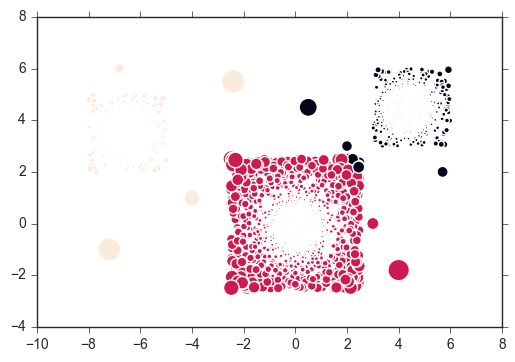

In [62]:
def main():
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('ex_kmc.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)
    
    #print('Train set: ' ,repr(len(trainingSet)))
    #print('Test set: ' + repr(len(testSet)))
    #print('Train set: ' ,trainingSet[0:10])
    #a=trainX[:,:-1].astype(np.float)
    #plt.scatter(a[:,0], a[:,1]);
    
    # k=군집개수, max_iter=반복 회수 제한(Hyper parameter)   
    k=3
    max_iter=100
    final_result=kmeans(trainX[:,:-1],k,max_iter)
    
    kmeans_result=final_result[0]
    centroid_result=final_result[1]
    Score=getNoveltyScore(kmeans_result,centroid_result,k)
    
    print('final cluster:',kmeans_result)
    print('final centroid:',centroid_result)
    print('Novelty Score:',Score)
    
    x=kmeans_result[:,0]
    y=kmeans_result[:,1]
    colors=kmeans_result[:,2]
    
    plt.scatter(x, y, s=(Score**3)*3, c=colors);

main()

### Absolute Distance기반 K-Means결과

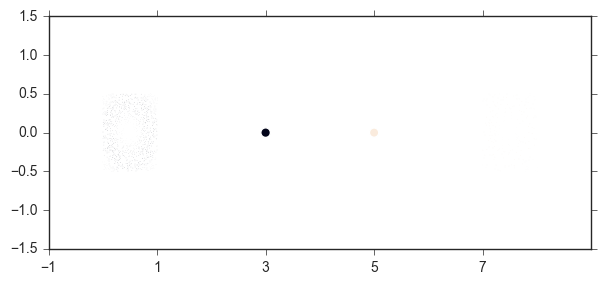

In [64]:
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

#파일로 데이터 입력(Column Name없이), 파일명 : ex_kmc.csv
def loadDataset(filename, split, trainingSet=[] , testSet=[]):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
        for x in range(len(dataset)):
            for y in range(2):
                dataset[x][y] = float(dataset[x][y])
            if random.random() < split:
                trainingSet.append(dataset[x])
            else:
                testSet.append(dataset[x])  
  
       
def kmeans(X,k,maxIt):
    numPoints,numDim=X.shape

    dataSet=np.zeros((numPoints,numDim+1))
    dataSet[:,:-1]=X
    centroids=dataSet[np.random.randint(numPoints,size=k),:]
    centroids[:,-1]=range(1,k+1)
    #print("centroids:",centroids)

    iterations=0;
    oldCentroids=None
    while not shouldStop(oldCentroids, centroids, iterations, maxIt):
        oldCentroids=np.copy(centroids)
        iterations+=1
        updateLabels(dataSet, centroids)
        centroids=getCentroids(dataSet, k)
    return dataSet, centroids

def shouldStop(oldCentroids,centroids,iterations,maxIt):
    if iterations>maxIt:
        return True
    return np.array_equal(oldCentroids, centroids)

def updateLabels(dataSet,centroids):
    numPoints,numDim=dataSet.shape
    for i in range(numPoints):
        dataSet[i,-1]=getLabelFromClosestCentroid(dataSet[i,:-1], centroids)

def getLabelFromClosestCentroid(dataSetRow,centroids):
    label=centroids[0,-1]
    minDist=np.linalg.norm(dataSetRow-centroids[0,:-1])
    for i in range(1,centroids.shape[0]):
        dist=np.linalg.norm(dataSetRow-centroids[i,:-1])
        if dist<minDist:
            minDist=dist
            label=centroids[i,-1]
            #print("label:"+str(label))
    return label

def getCentroids(dataSet,k):       
    result=np.zeros((k,dataSet.shape[1]))
    #print("result:",result)
    for i in range(1,k+1):
        oneCluster=dataSet[dataSet[:,-1]==i,:-1]
        #print("cluster:",oneCluster)
        result[i-1,:-1]=np.mean(oneCluster,axis=0)
        result[i-1,-1]=i
    #print("result:",result)
    return result

def getNoveltyScore(dataSetRow,centroids,k):
    minDist=[]    
    for i in range(k):
        Dist=np.linalg.norm(dataSetRow[:,:-1]-centroids[i,:-1],axis=1)   
        minDist.append(Dist)        
    NoveltyScore=np.min(minDist,axis=0)
    #print(minDist)
    #print(NoveltyScore)
    return NoveltyScore


def main():
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('ex_kmc2.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)
    
    #print('Train set: ' ,repr(len(trainingSet)))
    #print('Test set: ' + repr(len(testSet)))
    #print('Train set: ' ,trainingSet[0:10])
    #a=trainX[:,:-1].astype(np.float)
    #plt.scatter(a[:,0], a[:,1]);
    
    # k=군집개수, max_iter=반복 회수 제한(Hyper parameter)   
    k=2
    max_iter=100
    final_result=kmeans(trainX[:,:-1],k,max_iter)
    
    kmeans_result=final_result[0]
    centroid_result=final_result[1]
    Score=getNoveltyScore(kmeans_result,centroid_result,k)
    
    #print('final cluster:',kmeans_result)
    #print('final centroid:',centroid_result)
    #print('Novelty Score:',Score)
    
    x=kmeans_result[:,0]
    y=kmeans_result[:,1]
    colors=kmeans_result[:,2]
    
    plt.figure(figsize=(7, 3), dpi=80)
    plt.scatter(x, y, s=(Score**3)*3, c=colors);
    plt.xticks(np.arange(-1,8,2))
    plt.yticks(np.arange(-1.5,1.6,0.5))

main()

### Relative Distance기반 K-Means결과

final centroid: [[7.46097362 0.03209544 1.        ]
 [0.48733998 0.00989431 2.        ]]
maxDist: [2.4611828995070066, 2.5126795004093165]
Novelty Score: [0.27186787 0.36520021 0.47976108 ... 0.21707354 0.15544183 2.4611829 ]
final centroid_second: [[0.48363293 0.01017577 1.        ]
 [7.46139575 0.04082411 2.        ]]
maxDist_second: [0.6256093848117761, 0.6267617378211983]
Relative Novelty Score: [ 0.27154498  0.36890968  0.48328058 ...  1.09331664  0.76057093
 12.23714119]


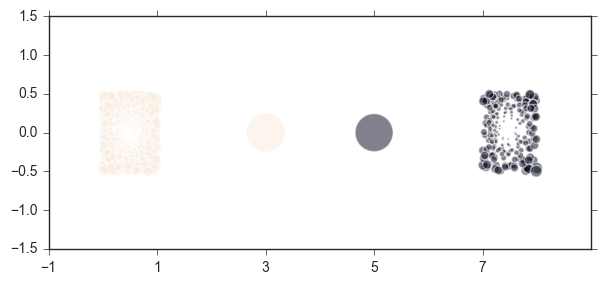

In [67]:
%matplotlib inline
import numpy as np
import random
import csv
import matplotlib.pyplot as plt


#파일로 데이터 입력(Column Name없이), 파일명 : ex_kmc.csv
def loadDataset(filename, split, trainingSet=[] , testSet=[]):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
        for x in range(len(dataset)):
            for y in range(2):
                dataset[x][y] = float(dataset[x][y])
            if random.random() < split:
                trainingSet.append(dataset[x])
            else:
                testSet.append(dataset[x])  
  
         
def kmeans(X,k,maxIt):
    numPoints,numDim=X.shape

    dataSet=np.zeros((numPoints,numDim+1))
    dataSet[:,:-1]=X
    centroids=dataSet[np.random.randint(numPoints,size=k),:]
    centroids[:,-1]=range(1,k+1)
    #print("centroids:",centroids)

    iterations=0;
    oldCentroids=None
    while not shouldStop(oldCentroids, centroids, iterations, maxIt):
        oldCentroids=np.copy(centroids)
        iterations+=1
        updateLabels(dataSet, centroids)
        centroids=getCentroids(dataSet, k)
    return dataSet, centroids


def shouldStop(oldCentroids,centroids,iterations,maxIt):
    if iterations>maxIt:
        return True
    return np.array_equal(oldCentroids, centroids)

def updateLabels(dataSet,centroids):
    numPoints,numDim=dataSet.shape
    for i in range(numPoints):
        dataSet[i,-1]=getLabelFromClosestCentroid(dataSet[i,:-1], centroids)

def getLabelFromClosestCentroid(dataSetRow,centroids):
    label=centroids[0,-1]
    minDist=np.linalg.norm(dataSetRow-centroids[0,:-1])
    for i in range(1,centroids.shape[0]):
        dist=np.linalg.norm(dataSetRow-centroids[i,:-1])
        if dist<minDist:
            minDist=dist
            label=centroids[i,-1]
            #print("label:"+str(label))
    return label


def getCentroids(dataSet,k):       
    result=np.zeros((k,dataSet.shape[1]))
    #print("result:",result)
    for i in range(1,k+1):
        oneCluster=dataSet[dataSet[:,-1]==i,:-1]
        #print("cluster:",oneCluster)
        result[i-1,:-1]=np.mean(oneCluster,axis=0)
        result[i-1,-1]=i
    #print("result:",result)
    return result


def getNoveltyScore(dataSetRow,centroids,k):
    minDist=[]  
    maxDist=[]
    for i in range(k):
        Dist=np.linalg.norm(dataSetRow[:,:-1]-centroids[i,:-1],axis=1)   
        minDist.append(Dist)     
    
    NoveltyScore=np.min(minDist,axis=0)
    min_index=np.argmin(minDist,axis=0)
    
    for i in range(k):
        clusterDist=NoveltyScore[np.where(min_index==i)]   
        maxDist.append(np.max(clusterDist))
    
#    a=centroids[min_index,-1]
#    print(a)
    #print(NoveltyScore)
    return NoveltyScore,maxDist


def getModNoveltyScore(kmeans_result,centroid_result,maxDist,k):
    minDist=[]
    countcluster=[]    
    for i in range(k):
        Dist=np.linalg.norm(kmeans_result[:,:-1]-centroid_result[i,:-1],axis=1)
        minDist.append(Dist)
        count=np.sum(kmeans_result[:,-1]==i+1)
        countcluster.append(count)           

    NoveltyScore=np.min(minDist,axis=0)
    weight=(countcluster/np.min(countcluster))/maxDist
    scale_weight=weight/np.min(weight)
    mod_NoveltyScore = NoveltyScore*np.repeat(scale_weight,countcluster,axis=0)

#    print(np.repeat(scale_weight,countcluster,axis=0))
#    print(countcluster)
#    print(np.min(countcluster))
#    print(scale_weight)
#    print(minDist)
#    print(MaxDist)
#    print(NoveltyScore)
   
    return mod_NoveltyScore


def main():
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('ex_kmc2.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)
    
    #print('Train set: ' ,repr(len(trainingSet)))
    #print('Test set: ' + repr(len(testSet)))
    #print('Train set: ' ,trainingSet[0:10])
    #a=trainX[:,:-1].astype(np.float)
    #plt.scatter(a[:,0], a[:,1]);
    
    # k=군집개수, max_iter=반복 회수 제한(Hyper parameter)   
    k=2
    max_iter=100
    final_result=kmeans(trainX[:,:-1],k,max_iter)

    kmeans_result=final_result[0]
    centroid_result=final_result[1]
    
    NoveltyScore_result=getNoveltyScore(kmeans_result,centroid_result,k)  
    Score=NoveltyScore_result[0]
    maxDist=NoveltyScore_result[1]
    
    print('final centroid:',centroid_result)
    print('maxDist:',maxDist)
    print('Novelty Score:',Score)


    #Outlier제거
    outlier_percentage=0.98
    Distsorting=np.argsort(Score)
    outlier_point=int(Distsorting.shape[0]*outlier_percentage)    
    cutoff_index=Distsorting[0:outlier_point]
    trainX=trainX[cutoff_index]
    
    #두번째 K-Means (새로운 Centroid와 군집의 크기(MaxDist)를 구함)
    final_result_second=kmeans(trainX[:,:-1],k,max_iter)
    kmeans_result_second=final_result_second[0]
    centroid_result_second=final_result_second[1]
    
    NoveltyScore_result_second=getNoveltyScore(kmeans_result_second,centroid_result_second,k)  
#    Score_second=NoveltyScore_result_second[0]
    maxDist_second=NoveltyScore_result_second[1]

    #Relative Distance기반의 Novelty Score    
    RelativeScore=getModNoveltyScore(kmeans_result,centroid_result_second,maxDist_second,k)

    print('final centroid_second:',centroid_result_second)
    print('maxDist_second:',maxDist_second)
    print('Relative Novelty Score:',RelativeScore)    
   
    x=kmeans_result[:,0]
    y=kmeans_result[:,1]
    colors=kmeans_result[:,2]
    
    plt.figure(figsize=(7, 3), dpi=80)
    plt.scatter(x, y, s=(RelativeScore**2)*5, c=colors,alpha=0.5);
    plt.xticks(np.arange(-1,8,2))
    plt.yticks(np.arange(-1.5,1.6,0.5))
    
main()

# PCA

In [68]:
%matplotlib inline
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

def loadDataset(filename, split, trainingSet=[] , testSet=[]):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
        for x in range(len(dataset)):
            for y in range(2):
                dataset[x][y] = float(dataset[x][y])
            if random.random() < split:
                trainingSet.append(dataset[x])
            else:
                testSet.append(dataset[x])

                
def pca(X,n): 

    #1st Step : subtract mean 
    avg = np.mean(X,axis=0)
    avg = np.tile(avg,(X.shape[0],1)) 
    X -= avg; 
    #print(avg)

    #2nd Step : covariance matrix 
    C = np.dot(X.transpose(),X)/(X.shape[0]-1)

    #3rd Step : Eigen Value, Eigen Vector 
    eig_values,eig_vecs = np.linalg.eig(C)

    #4rd Step : Select n개의 PC 
    idx = np.argsort(eig_values)[-n:][::-1]
    eig_values = eig_values[idx] 
    eig_vecs = eig_vecs[:,idx] 
    
    #print(eig_values.argsort())
    #print(eig_values.argsort()[-n:])
    #print(idx)
    #print(eig_values)
    #print(eig_vecs)
 
    #5th Step : new coordinate in new space 
    Y = np.dot(X,eig_vecs) 

    #6th Step : reconstruction 
    rec=np.dot(eig_vecs,Y.transpose())
    
    #Get NovetyScore
    Score=np.linalg.norm(X.transpose()-rec,axis=0)     
    
    #print(rec)
    #print(Score)
    
    return (X.transpose(), rec, Score.transpose(), eig_vecs, eig_values)


Eigen Value :  [1.24512068]
Eigen Vector :  [[0.72542851]
 [0.68829752]]
Data X :  [[-0.67161403 -0.44645554]
 [ 0.91438262  1.45595509]
 [-0.6448558  -1.02777988]
 [-2.2743718  -1.35273825]
 [-0.50774248 -1.26846451]
 [-1.00524144 -0.69462396]
 [ 1.25870619  1.45709821]
 [ 0.32823318 -0.26765691]
 [-1.87259869 -1.03672204]
 [ 0.62194987  0.82089709]]
Reconstruction :  [[-0.57635455 -0.5468539 ]
 [ 1.20816455  1.14632477]
 [-0.85253456 -0.80889766]
 [-1.87231685 -1.7764825 ]
 [-0.90055554 -0.8544607 ]
 [-0.87583795 -0.83100827]
 [ 1.3899344   1.31879075]
 [ 0.03908762  0.03708693]
 [-1.50309489 -1.42615913]
 [ 0.73718161  0.69944904]]
Novelty Score :  [0.1383987  0.42682404 0.30172818 0.58412958 0.57070243 0.18800517
 0.19065623 0.42008804 0.53683732 0.1674156 ]


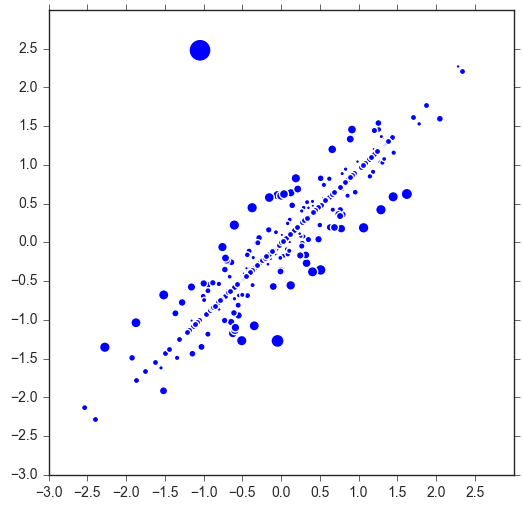

In [70]:
def main():

	# prepare data
    trainingSet=[]
    testSet=[]
    split = 0.8
    random.seed(100)
    loadDataset('ex_pca5.csv', split, trainingSet, testSet)
    #print('Train set: ' + repr(len(trainingSet)))
    #print('Test set: ' + repr(len(testSet)))

    # n=PC개수 (Hyper parameter)  
    n=1
    trainX=np.array(trainingSet)
    pca_result=pca(trainX[:,:-1].astype(np.float),n)

   # print('pca result:',pca_result)

    x=pca_result[0][0]
    y=pca_result[0][1]
    Score=pca_result[2]*100

    print('Eigen Value : ', pca_result[4])
    print('Eigen Vector : ', pca_result[3])    
    print('Data X : ', np.transpose(pca_result[0])[:10])
    print('Reconstruction : ', np.transpose(pca_result[1])[:10])
    print('Novelty Score : ', np.transpose(pca_result[2])[:10])
        
    x_rec=pca_result[1][0]
    y_rec=pca_result[1][1]
    
    plt.figure(figsize=(6, 6), dpi=80)
    plt.scatter(x,y,s=Score);
    plt.scatter(x_rec,y_rec,s=20);
    plt.xticks(np.arange(-3,3,0.5))
    plt.yticks(np.arange(-3,3,0.5))
         
main()